<a href="https://colab.research.google.com/github/codeworks-data/mvp-retail/blob/dev-hajar/Retail_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Scoping

## Data Collection

In progress

In [1]:
# In order to get the execution time of each cell
!pip install ipython-autotime
%load_ext autotime

time: 1.27 ms (started: 2021-02-11 07:24:59 +00:00)


In [2]:
import warnings
warnings.filterwarnings('ignore')

time: 1.23 ms (started: 2021-02-11 07:24:59 +00:00)


#Import libraries

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, date

#Plots
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

#ML
from sklearn.cluster import KMeans


time: 2.55 s (started: 2021-02-11 07:24:59 +00:00)


# Data Exploration

## Import Data

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive
time: 17.2 s (started: 2021-02-11 07:25:01 +00:00)


## Customers dataset

In [5]:
customers = pd.read_csv('/content/drive/MyDrive/datasets/archive/Customer.csv', decimal='.', low_memory=False) #index_col='customer_Id'

time: 887 ms (started: 2021-02-11 07:25:19 +00:00)


In [6]:
customers.head(3)

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0


time: 30.2 ms (started: 2021-02-11 07:25:19 +00:00)


In [7]:
customers.shape

(5647, 4)

time: 2.72 ms (started: 2021-02-11 07:25:19 +00:00)


In [8]:
customers.dtypes

customer_Id      int64
DOB             object
Gender          object
city_code      float64
dtype: object

time: 5.47 ms (started: 2021-02-11 07:25:19 +00:00)


In [9]:
customers['customer_Id'] = customers['customer_Id'].astype(str)
customers['city_code'] = customers['city_code'].astype(str)

time: 19.7 ms (started: 2021-02-11 07:25:20 +00:00)


In [10]:
customers['customer_Id'].nunique()

5647

time: 6.08 ms (started: 2021-02-11 07:25:20 +00:00)


In [11]:
customers.describe(include='object')

,customer_Id,DOB,Gender,city_code
count,5647,5647,5645,5647
unique,5647,4056,2,11
top,273823,27-12-1988,M,3.0
freq,1,7,2892,595


time: 85.2 ms (started: 2021-02-11 07:25:20 +00:00)


### Customer Gender

In [12]:
fig_gender = px.histogram(customers, x='Gender', title="Customers By Gender", color_discrete_sequence=['blueviolet'])
fig_gender.show()

time: 1.33 s (started: 2021-02-11 07:25:20 +00:00)


** Customer gender is uniformly distributed.


###  Customer Age

In [13]:
def calculate_age(born):
  "Calculate the customers' age as of late 2014 (the last year of recorded transactions)"
  last_date = pd.to_datetime('31-12-2014', format='%d-%m-%Y')
  return last_date.year - born.year - ((last_date.month, last_date.day) < (born.month, born.day))

time: 2.63 ms (started: 2021-02-11 07:25:21 +00:00)


In [14]:
customers['age'] = pd.to_datetime(customers['DOB'], format='%d-%m-%Y').apply(lambda x: calculate_age(x))

time: 944 ms (started: 2021-02-11 07:25:21 +00:00)


In [15]:
customers.head(3)

,customer_Id,DOB,Gender,city_code,age
0,268408,02-01-1970,M,4.0,44
1,269696,07-01-1970,F,8.0,44
2,268159,08-01-1970,F,8.0,44


time: 15.5 ms (started: 2021-02-11 07:25:22 +00:00)


In [16]:
customers['age'].describe()

count    5647.000000
mean       32.939968
std         6.614809
min        22.000000
25%        27.000000
50%        33.000000
75%        39.000000
max        44.000000
Name: age, dtype: float64

time: 9.92 ms (started: 2021-02-11 07:25:22 +00:00)


In [17]:
fig_DOB = px.histogram(customers, x="age", marginal="box", nbins=100, title="Customers By Age", # can be `box`, `violin`,
                         color_discrete_sequence=['mediumaquamarine'])
fig_DOB.show()

time: 378 ms (started: 2021-02-11 07:25:22 +00:00)


The customers' age is uniformly distributed.

In [18]:
#drop the DOB column
customers.drop('DOB', 1, inplace=True)

time: 3.11 ms (started: 2021-02-11 07:25:22 +00:00)


### Customer City Code

In [19]:
fig_code = px.histogram(customers, x='city_code', title="Customers By City Code", nbins=50)
fig_code.show()

time: 442 ms (started: 2021-02-11 07:25:22 +00:00)


There are 10 city codes in the dataset. And the customers are uniformly distributed across the 10 cities.

## Products Dataset

In [20]:
products = pd.read_csv('/content/drive/MyDrive/datasets/archive/prod_cat_info.csv', decimal='.', low_memory=False)

time: 388 ms (started: 2021-02-11 07:25:23 +00:00)


In [21]:
products.head(3)

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids


time: 17.1 ms (started: 2021-02-11 07:25:23 +00:00)


In [22]:
products.describe(include='object')

,prod_cat,prod_subcat
count,23,23
unique,6,18
top,Books,Women
freq,6,3


time: 21.5 ms (started: 2021-02-11 07:25:23 +00:00)


In [23]:
products.shape

(23, 4)

time: 3 ms (started: 2021-02-11 07:25:23 +00:00)


In [24]:
#Rename columns to match the columns in the transactions' dataset below.
products.rename(columns={"prod_sub_cat_code": "prod_subcat_code"}, inplace=True)

time: 2.9 ms (started: 2021-02-11 07:25:23 +00:00)


## Transactions Dataset

In [25]:
transactions = pd.read_csv('/content/drive/MyDrive/datasets/archive/Transactions.csv', decimal='.', low_memory=False) #index_col="transaction_id"

time: 784 ms (started: 2021-02-11 07:25:23 +00:00)


In [26]:
transactions.head(3)

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


time: 23.2 ms (started: 2021-02-11 07:25:24 +00:00)


In [27]:
transactions.shape

(23053, 10)

time: 2.98 ms (started: 2021-02-11 07:25:24 +00:00)


In [28]:
transactions.dtypes

transaction_id        int64
cust_id               int64
tran_date            object
prod_subcat_code      int64
prod_cat_code         int64
Qty                   int64
Rate                  int64
Tax                 float64
total_amt           float64
Store_type           object
dtype: object

time: 5.38 ms (started: 2021-02-11 07:25:24 +00:00)


In [29]:
transactions['transaction_id'].nunique()

20878

time: 4.53 ms (started: 2021-02-11 07:25:24 +00:00)


The repeated transaction_id concern returns and repeated returns. The latter we consider as a glitch and we'll get rid of it next.

In [30]:
transactions['transaction_id'] = transactions['transaction_id'].astype(str)
transactions.rename(columns={"cust_id": "customer_Id"}, inplace=True)
transactions['customer_Id'] = transactions['customer_Id'].astype(str)

time: 73.8 ms (started: 2021-02-11 07:25:24 +00:00)


In [31]:
# Some clients have double the return values. We have to drop those values.
transactions.drop_duplicates(subset=['customer_Id', 'Qty', 'Rate', 'total_amt', 'Store_type', 'Tax'], keep='first', inplace=True)

time: 18.7 ms (started: 2021-02-11 07:25:24 +00:00)


In [32]:
transactions.shape

(22934, 10)

time: 2.88 ms (started: 2021-02-11 07:25:24 +00:00)


In [33]:
#Correct the tran_date format
transactions['tran_date'] = pd.to_datetime(transactions['tran_date'].str.replace('/','-'), format='%d-%m-%Y')

time: 30 ms (started: 2021-02-11 07:25:24 +00:00)


In [34]:
transactions.dtypes

transaction_id              object
customer_Id                 object
tran_date           datetime64[ns]
prod_subcat_code             int64
prod_cat_code                int64
Qty                          int64
Rate                         int64
Tax                        float64
total_amt                  float64
Store_type                  object
dtype: object

time: 6.38 ms (started: 2021-02-11 07:25:24 +00:00)


In [35]:
#extract column with transaction year
transactions['tran_year'] = transactions['tran_date'].apply(lambda x: x.year).astype(str)#+ x.month for trans_month

time: 167 ms (started: 2021-02-11 07:25:24 +00:00)


### Merge with products dataset

In [36]:
transactions = pd.merge(transactions, products, on=['prod_cat_code','prod_subcat_code'])

time: 18.7 ms (started: 2021-02-11 07:25:24 +00:00)


In [37]:
transactions.head(3)

,transaction_id,customer_Id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,tran_year,prod_cat,prod_subcat
0,80712190438,270351,2014-02-28,1,1,-5,-772,405.30,-4265.30,e-Shop,2014,Clothing,Women
1,80712190438,270351,2014-02-20,1,1,5,772,405.30,4265.30,e-Shop,2014,Clothing,Women
2,73713102191,268867,2014-02-15,1,1,1,714,74.97,788.97,MBR,2014,Clothing,Women


time: 31.5 ms (started: 2021-02-11 07:25:25 +00:00)


### Revenue distribution by date

In [38]:
fig = px.histogram(transactions, x="tran_date", y="total_amt", histfunc="sum", title="Revenue distribution by date", color_discrete_sequence=['skyblue'])
fig.update_traces(xbins_size="M1")#M1, M2. M0 is for days, M1 for months.
fig.update_xaxes(showgrid=True, dtick="M1")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

time: 1.1 s (started: 2021-02-11 07:25:25 +00:00)


The sales are more or less uniformly distributed across the board.
The highest revenue seems to take place around march and april of each year.

Annual Revenue per customer

In [87]:
customers_trans_by_year = transactions.groupby(['customer_Id','tran_year'])['total_amt'].sum().reset_index().sort_values(by=['customer_Id','tran_year','total_amt'], ascending=True)

time: 36.1 ms (started: 2021-02-11 07:33:37 +00:00)


In [88]:
customers_trans_by_year.head(5)

,customer_Id,tran_year,total_amt
0,266783,2011,0.000
1,266783,2012,308.295
2,266783,2013,2805.595
3,266784,2012,5694.065
4,266785,2011,10047.765


time: 14.1 ms (started: 2021-02-11 07:33:38 +00:00)


In [89]:
customers_trans_by_year.dtypes

customer_Id     object
tran_year       object
total_amt      float64
dtype: object

time: 5.04 ms (started: 2021-02-11 07:33:43 +00:00)


In [90]:
# Clients who generated the most revenue per year
customers_trans_by_year.iloc[customers_trans_by_year['total_amt'].argsort()[-5:]]

,customer_Id,tran_year,total_amt
7509,271834,2011,23505.560
7873,272080,2012,23743.135
8917,272799,2011,24493.430
8250,272354,2013,25256.985
1237,267634,2013,29341.065


time: 18.3 ms (started: 2021-02-11 07:33:44 +00:00)


In [91]:
#Plot the revenues per client per year 
fig = px.scatter(customers_trans_by_year.head(100), x="customer_Id", y="total_amt", color='tran_year', size='total_amt',
                title="Customers' annual purchases")
fig.update_xaxes(tickangle=90, type ='category')
#fig.update_xaxes(tickangle=90, tickfont=dict(family='Rockwell', color='crimson', size=10), type='category')
fig.show()

time: 507 ms (started: 2021-02-11 07:33:47 +00:00)


The plot is pretty but a little hard to read!

In [81]:
# Let's plot more clearly the evolution of annual customer revenue
df_customer1 = customers_trans_by_year.loc[customers_trans_by_year['customer_Id']=='266794']
df_customer2 = customers_trans_by_year.loc[customers_trans_by_year['customer_Id']=='275231']
df_customer3 = customers_trans_by_year.loc[customers_trans_by_year['customer_Id']=='275206']
df_customer4 = customers_trans_by_year.loc[customers_trans_by_year['customer_Id']=='275241']
df_customer5 = customers_trans_by_year.loc[customers_trans_by_year['customer_Id']=='266788']
df_customer6 = customers_trans_by_year.loc[customers_trans_by_year['customer_Id']=='266841']
df_customer7 = customers_trans_by_year.loc[customers_trans_by_year['customer_Id']=='266810']
df_customer8 = customers_trans_by_year.loc[customers_trans_by_year['customer_Id']=='266846']
df_customer9 = customers_trans_by_year.loc[customers_trans_by_year['customer_Id']=='266785']

fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x=df_customer1["tran_year"], y=df_customer1["total_amt"],
                    mode='lines+markers',
                    name='Customer 1',
                    ))
fig.add_trace(go.Scatter(x=df_customer2["tran_year"], y=df_customer2["total_amt"],
                    mode='lines+markers',
                    name='Customer 2'))
fig.add_trace(go.Scatter(x=df_customer3["tran_year"], y=df_customer3["total_amt"],
                    mode='lines+markers',
                    name='Customer 3'))
fig.add_trace(go.Scatter(x=df_customer4["tran_year"], y=df_customer4["total_amt"],
                    mode='lines+markers',
                    name='Customer 4'))

fig.add_trace(go.Scatter(x=df_customer5["tran_year"], y=df_customer5["total_amt"],
                    mode='lines+markers',
                    name='Customer 5',
                    ))
fig.add_trace(go.Scatter(x=df_customer6["tran_year"], y=df_customer6["total_amt"],
                    mode='lines+markers',
                    name='Customer 6'))
fig.add_trace(go.Scatter(x=df_customer7["tran_year"], y=df_customer7["total_amt"],
                    mode='lines+markers',
                    name='Customer 7'))
fig.add_trace(go.Scatter(x=df_customer8["tran_year"], y=df_customer8["total_amt"],
                    mode='lines+markers',
                    name='Customer 8'))
            
fig.add_trace(go.Scatter(x=df_customer9["tran_year"], y=df_customer9["total_amt"],
                    mode='lines+markers',
                    name='Customer 9'))

fig.update_xaxes(tickangle=90, type ='category')
fig.update_xaxes(categoryorder='category ascending')

fig.update_layout(
    title="Annual revenue per customer",
    xaxis_title="Year",
    yaxis_title="Revenue",
)

fig.show()

time: 248 ms (started: 2021-02-11 07:30:11 +00:00)


In [45]:
# Clients who generated the least revenue
customers_trans_by_year.iloc[customers_trans_by_year['total_amt'].argsort()[:5]]

,customer_Id,tran_year,total_amt
6940,271458,2012,-6663.150
4070,269517,2013,-4442.100
8186,272317,2014,-3629.925
1710,267959,2014,-3478.540
8665,272629,2013,-3337.100


time: 21.2 ms (started: 2021-02-11 07:25:27 +00:00)


In [46]:
transactions.loc[transactions['customer_Id']=='271458']

,transaction_id,customer_Id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,tran_year,prod_cat,prod_subcat
20635,61827274578,271458,2012-01-04,2,6,-5,-1206,633.15,-6663.15,e-Shop,2012,Home and kitchen,Furnishing
20641,61827274578,271458,2011-12-30,2,6,5,1206,633.15,6663.15,e-Shop,2011,Home and kitchen,Furnishing


time: 35.7 ms (started: 2021-02-11 07:25:27 +00:00)


For those customers with the negative yearly revenue, it is due to puchases in one year and the return of those purchases in the following year. With no other puchases in the year in question, their revenue stays in the negative.

### Annual Revenue by category

In [47]:
category_trans = transactions.groupby(['prod_cat', 'tran_year'])['total_amt'].sum().reset_index().sort_values(by=['tran_year', 'total_amt'], ascending=True)
category_trans.shape

(24, 3)

time: 19 ms (started: 2021-02-11 07:25:27 +00:00)


In [48]:
category_trans.head(6)

,prod_cat,tran_year,total_amt
0,Bags,2011,1300524.225
8,Clothing,2011,1783683.265
16,Footwear,2011,1854123.700
20,Home and kitchen,2011,2608393.385
12,Electronics,2011,3271600.020
4,Books,2011,4016183.275


time: 16.2 ms (started: 2021-02-11 07:25:27 +00:00)


In [49]:
transactions.loc[transactions['prod_cat']=='Books'].total_amt.max()

8281.975

time: 11 ms (started: 2021-02-11 07:25:27 +00:00)


In [50]:
transactions.loc[transactions['prod_cat']=='Electronics'].total_amt.max()

8287.5

time: 10 ms (started: 2021-02-11 07:25:27 +00:00)


In [51]:
fig = px.scatter(category_trans, x="prod_cat", y="total_amt", color='tran_year', size='total_amt', 
                 title="Annual total revenue per product category")
fig.update_xaxes(tickangle=90, type='category')
#fig.update_xaxes(tickangle=90, tickfont=dict(family='Rockwell', color='crimson', size=10), type='category')
fig.show()

time: 363 ms (started: 2021-02-11 07:25:27 +00:00)


In [52]:
# Let's use a line to plot the annual evolution of revenue per category
df_cat_1 = category_trans.loc[category_trans['prod_cat']=='Books']
df_cat_2 = category_trans.loc[category_trans['prod_cat']=='Electronics']
df_cat_3 = category_trans.loc[category_trans['prod_cat']=='Home and kitchen']
df_cat_4 = category_trans.loc[category_trans['prod_cat']=='Footwear']
df_cat_5 = category_trans.loc[category_trans['prod_cat']=='Clothing']
df_cat_6 = category_trans.loc[category_trans['prod_cat']=='Bags']

fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x=df_cat_1["tran_year"], y=df_cat_1["total_amt"],
                    mode='lines+markers',
                    name='Books',
                    ))
fig.add_trace(go.Scatter(x=df_cat_2["tran_year"], y=df_cat_2["total_amt"],
                    mode='lines+markers',
                    name='Electronics',
                    ))

fig.add_trace(go.Scatter(x=df_cat_3["tran_year"], y=df_cat_3["total_amt"],
                    mode='lines+markers',
                    name='Home and kitchen',
                    ))
fig.add_trace(go.Scatter(x=df_cat_4["tran_year"], y=df_cat_4["total_amt"],
                    mode='lines+markers',
                    name='Footwear',
                    ))

fig.add_trace(go.Scatter(x=df_cat_5["tran_year"], y=df_cat_5["total_amt"],
                    mode='lines+markers',
                    name='Clothing',
                    ))
fig.add_trace(go.Scatter(x=df_cat_6["tran_year"], y=df_cat_6["total_amt"],
                    mode='lines+markers',
                    name='Bags',
                    ))

fig.update_xaxes(tickangle=90, type ='category')
fig.update_xaxes(categoryorder='category ascending')

fig.update_layout(
    title="Annual revenue per category",
    xaxis_title="Year",
    yaxis_title="Revenue",
)

fig.show()

time: 208 ms (started: 2021-02-11 07:25:27 +00:00)


### Repeated purchases

Books and electronics have the best sales across the board.

### Store Type

In [53]:
fig_store = px.histogram(transactions, x='Store_type', title="Transactions by store type", color_discrete_sequence=['indianred'])
fig_store.show()

time: 614 ms (started: 2021-02-11 07:25:27 +00:00)


The e-Shop records the most transactions. The rest of the stores record the same number of transactions.

### Returns

We consider negative total_amt as returns.

In [54]:
returns = transactions.loc[transactions['total_amt']<0]
returns.shape

(2059, 13)

time: 5.59 ms (started: 2021-02-11 07:25:28 +00:00)


In [55]:
returns.dtypes

transaction_id              object
customer_Id                 object
tran_date           datetime64[ns]
prod_subcat_code             int64
prod_cat_code                int64
Qty                          int64
Rate                         int64
Tax                        float64
total_amt                  float64
Store_type                  object
tran_year                   object
prod_cat                    object
prod_subcat                 object
dtype: object

time: 4.64 ms (started: 2021-02-11 07:25:28 +00:00)


In [56]:
returns['tran_year'].value_counts()

2012    683
2013    640
2011    631
2014    105
Name: tran_year, dtype: int64

time: 5.64 ms (started: 2021-02-11 07:25:28 +00:00)


In [57]:
fig = px.histogram(returns, x='tran_year', color='prod_cat', title=" Annual returns' count per store type") #color='Store_type'
fig.update_xaxes(type='category')
fig.show()

time: 466 ms (started: 2021-02-11 07:25:28 +00:00)


Books and Electronics have the most returns per year. Which is consitent with the fact that they record the most transactions overall.

In [58]:
#Group the return by customer
returns_by_customer = returns.groupby(['customer_Id'])['total_amt'].sum().reset_index().sort_values(by=['customer_Id', 'total_amt'], ascending=False)
returns_by_customer.head(3)

,customer_Id,total_amt
1727,275261,-3263.065
1726,275257,-1150.305
1725,275252,-8607.950


time: 29.6 ms (started: 2021-02-11 07:25:29 +00:00)


In [59]:
#Customers with the most returns
returns_by_customer.sort_values('total_amt').iloc[:5]

,customer_Id,total_amt
1068,271862,-16241.290
744,270353,-14902.030
923,271176,-14370.525
227,267943,-14039.025
552,269539,-13714.155


time: 16.5 ms (started: 2021-02-11 07:25:29 +00:00)


In [60]:
fig = px.histogram(returns, x="tran_date", y=returns['total_amt']*-1, histfunc="sum", title="Total amount of returns by date" , color_discrete_sequence=['navy'])
fig.update_traces(xbins_size="M1")#M1, M2 M0 is for days, M1 for months
fig.update_xaxes(showgrid=True, dtick="M1")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

time: 537 ms (started: 2021-02-11 07:25:29 +00:00)


# Customer Segmentation


## Create RFM features (market research)

In [92]:
# Function to create recency, frequency and monetary value
def create_RFM_columns(df_transactions, customer_id_column_name, transaction_date_column_name, purchase_amount_column_name):

  # Select only unique customer IDs
  df_customer_RFM = df_transactions.groupby(customer_id_column_name)
  df_customer_RFM  = pd.DataFrame(df_transactions[customer_id_column_name].unique(), columns=[customer_id_column_name])
  df_customer_RFM[customer_id_column_name].astype(str)

  # Create Dataframe of unique customers and their most recent transaction
  df_recency = df_transactions.groupby(customer_id_column_name)[transaction_date_column_name].max().reset_index()
  df_recency.columns = [customer_id_column_name, transaction_date_column_name]
  df_recency[transaction_date_column_name] = pd.to_datetime(df_recency[transaction_date_column_name])
  df_recency['recency'] = (df_recency[transaction_date_column_name].max() - df_recency[transaction_date_column_name]).dt.days
  df_recency = df_recency.drop(transaction_date_column_name, axis=1)
  df_recency['recency'].astype('int')
    
  # Get transaction counts for each customer and create dataframe
  # Frequency is determined by repeat purchases: (Order count - 1 ?) or not ?
  df_frequency = df_transactions.groupby(customer_id_column_name)[transaction_date_column_name].count().reset_index()
  df_frequency.columns = [customer_id_column_name,'frequency']
  df_frequency['frequency'] = df_frequency['frequency'] 

  # Get total order revenue for each unique customer
  df_monetary_value = df_transactions.groupby(customer_id_column_name)[purchase_amount_column_name].mean().reset_index()
    
  # Merge data
  df_customers = [df_frequency, df_recency, df_monetary_value]

  for df in df_customers:
    df_customer_RFM  = pd.merge(df_customer_RFM , df, on=customer_id_column_name) 

  df_customer_RFM['customer_Id'] = df_customer_RFM['customer_Id'].astype('str')
        
  return df_customer_RFM

time: 23.7 ms (started: 2021-02-11 08:19:03 +00:00)


In [93]:
#create df with RFM metrics
customer_RFM = create_RFM_columns(transactions, 'customer_Id', 'tran_date', 'total_amt')
customer_RFM.rename(columns={"total_amt": "monetary_value"}, inplace=True)

time: 70.6 ms (started: 2021-02-11 08:19:05 +00:00)


We get the following dataframe as an output.

In [63]:
customer_RFM.describe()

,frequency,recency,monetary_value
count,5506.000000,5506.000000,5506.000000
mean,4.165274,282.193970,2223.948491
std,2.094741,243.626918,1235.858759
min,1.000000,0.000000,0.000000
25%,3.000000,91.000000,1332.630000
50%,4.000000,211.000000,2081.820000
75%,5.000000,404.000000,2943.305625
max,13.000000,1129.000000,8204.625000


time: 34.2 ms (started: 2021-02-11 07:25:29 +00:00)


### Recency

How recently did the customer purchase?

The recency averages at 282 days. The least  active customer hasn't made a transaction in 3 years. The recency distribution is positively skewed.

In [95]:
fig_recency = px.histogram(customer_RFM, x='recency', title="Customer Recency", marginal="box" , color_discrete_sequence=['tomato'])
fig_recency.show()

time: 353 ms (started: 2021-02-11 08:19:19 +00:00)


### Frequency

How often do they purchase?

The average customer made about 4 transactions in the 3 years we analysed.

In [96]:
fig_frequency = px.histogram(customer_RFM, x='frequency', title="Customer Frequency", marginal="box", color_discrete_sequence=['yellowgreen'])
fig_frequency.show()

time: 345 ms (started: 2021-02-11 08:19:23 +00:00)


### Monetary value

The average customer spent 2224 in monetary value over the course of the threes years. The monetary value is also right skewed.

In [97]:
fig_monetary = px.histogram(customer_RFM, x='monetary_value', title="Customer Monetary Value", marginal="box" , color_discrete_sequence=['teal']) 
fig_monetary.show()

time: 564 ms (started: 2021-02-11 08:19:27 +00:00)


Now that we have the three columns on hand. We move on to clustering by feature. For this purpose, we will call on the magic of machine learning. We use K-means, an unsupervised learning algorithm that uses the geometrical principle to determine the best suited cluster for each data point. 
In order to determine the optimal number of clusters to input into the k-means algorithm, we use SSE plots (elbow plots).

## Clustering by feature

#### Elbow plots

frequency


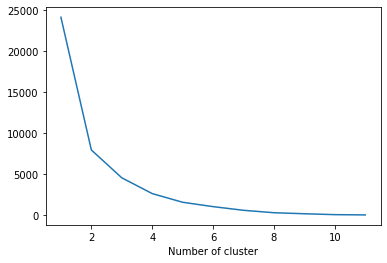

recency


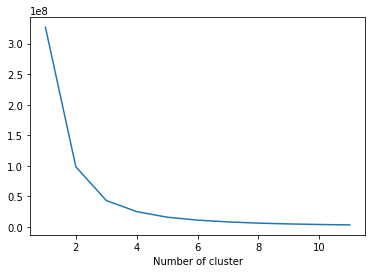

monetary_value


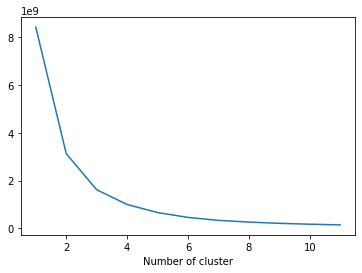

time: 5.7 s (started: 2021-02-11 08:19:40 +00:00)


In [98]:
def generate_SSE_plot(df, col_to_plot=None):
    '''
    This function takes in one column of
    the RFM dataframe as a string
    and will plot a KMeans elbow plot of the 
    sum of squared estimate. Where the elbow
    bends will determine how many clusters are
    optimal for the Kmeans clustering.
    '''
    sse={}
    if col_to_plot:
        km_var = df[[col_to_plot]].copy()
    else:
        km_var = df.copy()
    for k in range(1, 12):
        kmeans = KMeans(n_clusters=k, max_iter=10000).fit(km_var)
        km_var["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
#     plt.title(str(km_var))
    plt.show();

for col in ['frequency', 'recency', 'monetary_value']:
    print(col)
    generate_SSE_plot(customer_RFM, col)

It seem that 3 is the optimal number of clusters for the 3 features.

In [99]:
#function for ordering cluster numbers
def reorder_cluster_labels_by_mean_field(df, cluster_field_name, target_field_name, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

time: 5.44 ms (started: 2021-02-11 08:19:45 +00:00)


#### Recency

In [100]:
#build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer_RFM[['recency']])
customer_RFM['recency_cluster'] = kmeans.predict(customer_RFM[['recency']])

#order the recency cluster
customer_RFM = reorder_cluster_labels_by_mean_field(customer_RFM, 'recency_cluster', 'recency', False)#False because the higher the recency the worse the customer

#see details of each cluster
customer_RFM.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,667.0,792.745127,142.274903,592.0,672.50,773.0,894.5,1129.0
1,1732.0,389.867206,93.593481,252.0,309.75,377.0,462.0,591.0
2,3107.0,112.568072,68.936359,0.0,52.00,105.0,167.0,251.0


time: 126 ms (started: 2021-02-11 08:19:45 +00:00)


#### Frequency

In [101]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer_RFM[['frequency']])
customer_RFM['frequency_cluster'] = kmeans.predict(customer_RFM[['frequency']])

#order the frequency cluster
customer_RFM = reorder_cluster_labels_by_mean_field(customer_RFM, 'frequency_cluster', 'frequency', True)

#see details of each cluster
customer_RFM.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,2316.0,2.245682,0.765116,1.0,2.0,2.0,3.0,3.0
1,2445.0,4.836810,0.805537,4.0,4.0,5.0,6.0,6.0
2,745.0,7.928859,1.173881,7.0,7.0,8.0,9.0,13.0


time: 80.6 ms (started: 2021-02-11 08:19:47 +00:00)


#### Monetary Value

In [102]:
#apply clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(customer_RFM[['monetary_value']])
customer_RFM['monetary_value_cluster'] = kmeans.predict(customer_RFM[['monetary_value']])

#order the cluster numbers
customer_RFM = reorder_cluster_labels_by_mean_field(customer_RFM, 'monetary_value_cluster', 'monetary_value', True)

#see details of each cluster
customer_RFM.groupby('monetary_value_cluster')['monetary_value'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_value_cluster,,,,,,,,
0,2286.0,1121.740974,478.976884,0.000,772.560750,1194.799667,1519.712639,1829.32750
1,2405.0,2542.878323,453.064999,1829.659,2152.816250,2506.140000,2908.083750,3455.61125
2,815.0,4374.402650,858.279827,3461.302,3737.579625,4101.760000,4717.245000,8204.62500


time: 143 ms (started: 2021-02-11 08:19:49 +00:00)


In [103]:
customer_RFM.head(3)

,customer_Id,frequency,recency,monetary_value,recency_cluster,frequency_cluster,monetary_value_cluster
0,270351,5,0,1153.841,2,1,0
1,268867,5,13,463.658,2,1,0
2,274917,5,21,806.871,2,1,0


time: 33.9 ms (started: 2021-02-11 08:19:50 +00:00)


### Overall Score

In [104]:
#compute overall score and use mean() to see details
customer_RFM['overall_score'] = customer_RFM['recency_cluster'] + customer_RFM['frequency_cluster'] + customer_RFM['monetary_value_cluster']

time: 2.37 ms (started: 2021-02-11 08:19:51 +00:00)


In [105]:
customer_RFM.groupby('overall_score')['recency','frequency','monetary_value'].mean()

,recency,frequency,monetary_value
overall_score,,,
0,832.706612,1.747934,934.537769
1,555.192110,2.454545,1518.162975
2,369.523851,3.114484,1953.253374
3,223.371891,4.095771,2243.701273
4,134.950390,5.307583,2621.600432
5,103.597980,6.676768,3074.537453
6,116.357143,7.785714,3776.157377


time: 17.1 ms (started: 2021-02-11 08:19:52 +00:00)


The customers with '6' score are the best cutomers, and the the ones with the '0' score are the worst.

0 to 2: Low Value

3 to 4: Mid Value

5+: High Value

In [75]:
#Label the customers based on their overall score 
customer_RFM['segment'] = 'Low'
customer_RFM.loc[customer_RFM['overall_score']>1,'segment'] = 'Mid' 
customer_RFM.loc[customer_RFM['overall_score']>4,'segment'] = 'High' 

time: 9.8 ms (started: 2021-02-11 07:25:37 +00:00)


#### Recency vs Monetary Value

In [76]:
fig = px.scatter(customer_RFM, x="recency", y="monetary_value", color="segment", title="Recency and monetary value by segment"
                )
fig.show()

time: 362 ms (started: 2021-02-11 07:25:37 +00:00)


#### Recency vs Frequency

In [77]:
fig = px.scatter(customer_RFM, x="recency", y="frequency", color="segment", title="Recency and frequency by segment")
fig.show()

time: 536 ms (started: 2021-02-11 07:25:37 +00:00)


#### Frequency vs Monetary Value

In [78]:
fig = px.scatter(customer_RFM, x="frequency", y="monetary_value", color="segment", title="frequency and monetary value by segment"
                )
fig.show()

time: 367 ms (started: 2021-02-11 07:25:38 +00:00)


In [79]:
fig = px.scatter_3d(customer_RFM, x="frequency", y="monetary_value", z='recency', color="segment", title="Recency, frequency and monetary value by segment")
fig.show()

time: 395 ms (started: 2021-02-11 07:25:38 +00:00)
